<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/DSMC_Cavity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.interpolate import griddata

# برای نتایج تکرارپذیر، یک دانه تصادفی تنظیم می‌کنیم
tf.random.set_seed(42)
np.random.seed(42)

In [14]:
import re
import numpy as np
import pandas as pd

def parse_tecplot_block_ascii(file_path):
    """
    Parses a Tecplot ASCII file.
    This definitive version uses a robust method to extract the multi-line variable list
    and correctly identifies the data block.
    """
    print(f"Parsing file: {file_path}...")
    try:
        with open(file_path, 'r') as f:
            content = f.read()

        # --- Extract Variables using a robust method ---
        # Find the entire block of text between "VARIABLES =" and "ZONE"
        var_block_match = re.search(r'VARIABLES\s*=\s*(.*?)ZONE', content, re.IGNORECASE | re.DOTALL)
        if not var_block_match:
            raise ValueError("Could not find a block between VARIABLES and ZONE.")

        var_block_str = var_block_match.group(1)
        variables = re.findall(r'"(.*?)"', var_block_str)

        if not variables:
            raise ValueError("No variables found in the VARIABLES block.")

        num_vars = len(variables)

        # --- Extract Metadata (I, J dimensions) ---
        zone_header_match = re.search(r'ZONE.*?(I\s*=\s*(\d+)).*?(J\s*=\s*(\d+))', content, re.IGNORECASE | re.DOTALL)
        if not zone_header_match:
            raise ValueError("Could not find I= and J= dimensions in the ZONE block.")

        i_dim = int(zone_header_match.group(2))
        j_dim = int(zone_header_match.group(4))
        num_points = i_dim * j_dim

        metadata = {'I': i_dim, 'J': j_dim, 'variables': variables}

        # --- Find the exact start of the numerical data ---
        dt_line_match = re.search(r'DT\s*=\s*\(.*\)', content, re.IGNORECASE)
        if not dt_line_match:
            raise ValueError("Could not find the DT=(...) line to mark the start of data.")

        data_start_index = dt_line_match.end()
        data_str = content[data_start_index:]

        flat_data = np.fromstring(data_str, sep=' ')

        expected_size = num_vars * num_points
        if flat_data.size < expected_size:
            raise ValueError(f"Data size mismatch. Expected {expected_size} points, but found only {flat_data.size}.")

        flat_data = flat_data[:expected_size]
        block_data = flat_data.reshape((num_vars, num_points))
        df = pd.DataFrame(block_data.T, columns=variables)

        print(f"Successfully parsed {num_points} points and {num_vars} variables.")
        return df, metadata

    except Exception as e:
        print(f"An error occurred while parsing {file_path}: {e}")
        return pd.DataFrame(), {}

In [21]:
# --- گام ۳: بارگذاری و پیش‌پردازش تمام داده‌ها (نسخه نهایی) ---
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# --- تعریف دقیق نام فایل‌ها و عدد Knudsen مربوط به هرکدام ---
file_kn_map = {
    'CavityKn10': 10.0,
    'CavityKn1': 1.0,
    'CavityKn0.5': 0.5,
    'CavityKn0.1': 0.1,
    'CavityKn0.01': 0.01,
    'CavityKn0.001': 0.001
}

# --- انتخاب یک فایل برای تست ---
test_kn_value = 0.1
test_basename = [name for name, kn in file_kn_map.items() if kn == test_kn_value][0]

print(f"Test file chosen for validation: {test_basename} (Kn = {test_kn_value})")

# --- بارگذاری تمام داده‌ها ---
DATA_DIR = './'
all_dfs = []
metadata = None

for basename, kn in file_kn_map.items():
    filepath_dat = os.path.join(DATA_DIR, f"{basename}.dat")
    filepath_txt = os.path.join(DATA_DIR, f"{basename}.txt")

    filepath = None
    if os.path.exists(filepath_dat):
        filepath = filepath_dat
    elif os.path.exists(filepath_txt):
        filepath = filepath_txt
    else:
        print(f"هشدار: فایل داده برای '{basename}' پیدا نشد. از این فایل صرف نظر می‌شود.")
        continue

    df, current_metadata = parse_tecplot_block_ascii(filepath)
    if not df.empty:
        df['Kn'] = kn
        all_dfs.append(df)
        metadata = current_metadata

if not all_dfs:
    raise FileNotFoundError("هیچ‌کدام از فایل‌های داده بر اساس نقشه تعریف‌شده، پیدا نشد.")

# --- ساخت مجموعه داده‌های آموزشی و تست ---
train_df_list = [df for df in all_dfs if df['Kn'].iloc[0] != test_kn_value]
test_df = next((df for df in all_dfs if df['Kn'].iloc[0] == test_kn_value), None)

if not train_df_list or test_df is None:
    raise ValueError("خطا در تقسیم‌بندی داده‌های آموزشی و تست. لطفاً فایل‌ها را بررسی کنید.")

train_df = pd.concat(train_df_list, ignore_index=True)

I, J = metadata['I'], metadata['J']

# --- آماده‌سازی داده‌ها برای شبکه عصبی ---
input_features = ['X', 'Y', 'Kn']
output_features = [v for v in metadata['variables'] if v not in ['X', 'Y']]

X_train = train_df[input_features].copy()
y_train = train_df[output_features].copy()
X_test = test_df[input_features].copy()
y_test = test_df[output_features].copy()

# اعمال تبدیل لگاریتمی بر روی Kn
X_train['Kn'] = np.log10(X_train['Kn'])
X_test['Kn'] = np.log10(X_test['Kn'])

# --- نرمال‌سازی داده‌ها ---
pos_scaler = MinMaxScaler()
kn_scaler = StandardScaler()
y_scaler = StandardScaler() # استفاده از StandardScaler برای پشتیبانی از مقادیر منفی

# Fit on training data and transform both sets
X_train_scaled = np.zeros_like(X_train, dtype=float)
X_train_scaled[:, :2] = pos_scaler.fit_transform(X_train[['X', 'Y']])
X_train_scaled[:, 2:] = kn_scaler.fit_transform(X_train[['Kn']])
y_train_scaled = y_scaler.fit_transform(y_train)

X_test_scaled = np.zeros_like(X_test, dtype=float)
X_test_scaled[:, :2] = pos_scaler.transform(X_test[['X', 'Y']])
X_test_scaled[:, 2:] = kn_scaler.transform(X_test[['Kn']])

print("\nپیش‌پردازش داده‌ها با موفقیت انجام شد.")
print(f"شکل مجموعه داده آموزشی: {X_train_scaled.shape}")
print(f"شکل مجموعه داده تست: {X_test_scaled.shape}")

Test file chosen for validation: CavityKn0.1 (Kn = 0.1)
Parsing file: ./CavityKn10.dat...
Successfully parsed 2500 points and 11 variables.
Parsing file: ./CavityKn1.dat...
Successfully parsed 2500 points and 11 variables.
هشدار: فایل داده برای 'CavityKn0.5' پیدا نشد. از این فایل صرف نظر می‌شود.
Parsing file: ./CavityKn0.1.dat...
Successfully parsed 2500 points and 11 variables.
هشدار: فایل داده برای 'CavityKn0.01' پیدا نشد. از این فایل صرف نظر می‌شود.
هشدار: فایل داده برای 'CavityKn0.001' پیدا نشد. از این فایل صرف نظر می‌شود.

پیش‌پردازش داده‌ها با موفقیت انجام شد.
شکل مجموعه داده آموزشی: (5000, 3)
شکل مجموعه داده تست: (2500, 3)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ position_input      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kn_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fourier_features_3  │ (None, 128)       │          0 │ position_input[0… │
│ (FourierFeatures)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │         64 │ kn_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     16,512 │ fourier_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      1,056 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_batch_norm     │ (None, 128)       │      8,704 │ dense_17[0][0],   │
│ (CondBatchNorm)     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128)       │          0 │ cond_batch_norm[… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 128)       │     16,512 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cond_batch_norm_1   │ (None, 128)       │      8,704 │ dense_20[0][0],   │
│ (CondBatchNorm)     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ cond_batch_norm_… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 128)       │     16,512 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 9)         │      1,161 │ dense_23[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,225 (270.41 KB)

 Trainable params: 68,713 (268.41 KB)

 Non-trainable params: 512 (2.00 KB)


شروع فرایند آموزش با معماری پیشرفته Conditional Normalization...
Epoch 1/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - loss: 0.8291 - val_loss: 1.6834 - learning_rate: 0.0010
Epoch 2/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.7422 - val_loss: 1.7020 - learning_rate: 0.0010
Epoch 3/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.6491 - val_loss: 1.7151 - learning_rate: 0.0010
Epoch 4/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.5476 - val_loss: 1.7184 - learning_rate: 0.0010
Epoch 5/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.4672 - val_loss: 1.7301 - learning_rate: 0.0010
Epoch 6/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.4574 - val_loss: 1.7257 - learning_rate: 0.0010
Epoch 7/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.4683 - val_loss: 1.6735 - learning_rate: 0.0010
Epoch 8/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4478 - val_loss: 1.6554 - learning_rate: 0.0010
Epoch 9/2000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.

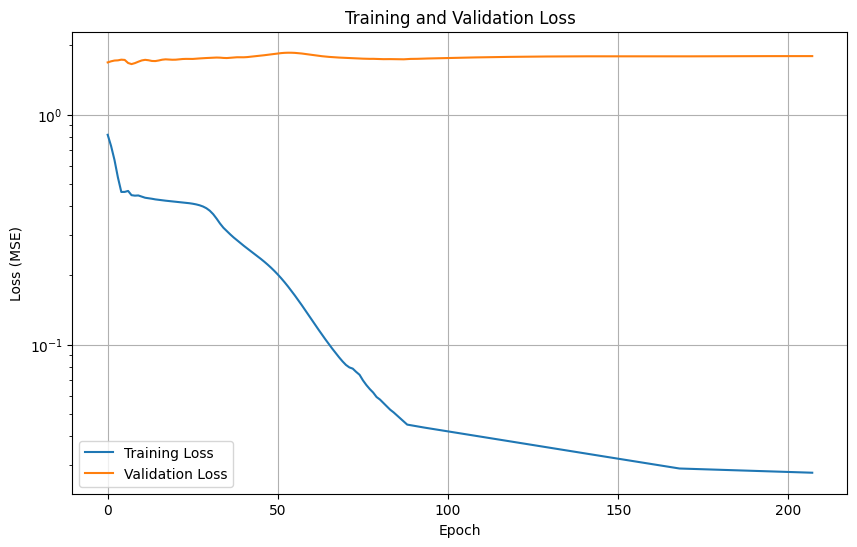

In [24]:
# --- گام ۴: ساخت و آموزش مدل (نسخه نهایی با Conditional Batch Normalization) ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- تعریف لایه ویژگی‌های فوریه ---
class FourierFeatures(layers.Layer):
    def __init__(self, output_dims, scale=10.0):
        super(FourierFeatures, self).__init__()
        self.output_dims = output_dims
        self.scale = scale
        self.B = tf.random.normal([2, self.output_dims // 2], stddev=self.scale)

    def call(self, x):
        x_proj = 2 * np.pi * x @ self.B
        return tf.concat([tf.sin(x_proj), tf.cos(x_proj)], axis=-1)

# --- لایه سفارشی برای Conditional Batch Normalization ---
class CondBatchNorm(layers.Layer):
    def __init__(self, **kwargs):
        super(CondBatchNorm, self).__init__(**kwargs)
        self.batch_norm = layers.BatchNormalization(center=False, scale=False) # BN بدون پارامترهای داخلی

    def build(self, input_shape):
        feature_shape, cond_shape = input_shape
        self.gamma_dense = layers.Dense(feature_shape[-1], activation='linear')
        self.beta_dense = layers.Dense(feature_shape[-1], activation='linear')

    def call(self, inputs):
        features, cond = inputs
        # نرمال‌سازی ویژگی‌های اصلی
        normalized_features = self.batch_norm(features)
        # تولید پارامترهای گاما و بتا از ورودی شرطی (Knudsen)
        gamma = self.gamma_dense(cond)
        beta = self.beta_dense(cond)
        # اعمال شیفت و مقیاس
        return normalized_features * gamma + beta

# --- ساخت مدل پیشرفته ---
POS_EMBED_DIMS = 128
KN_EMBED_DIMS = 32
NUM_OUTPUTS = y_train.shape[1]

# ورودی‌ها
pos_input = keras.Input(shape=(2,), name='position_input')
kn_input = keras.Input(shape=(1,), name='kn_input')

# شبکه کوچک برای پردازش عدد Knudsen
kn_embedding = layers.Dense(KN_EMBED_DIMS, activation='swish')(kn_input)
kn_embedding = layers.Dense(KN_EMBED_DIMS, activation='swish')(kn_embedding)

# پردازش ورودی مکانی با ویژگی‌های فوریه
ff_layer = FourierFeatures(POS_EMBED_DIMS)(pos_input)
x = layers.Dense(POS_EMBED_DIMS)(ff_layer)

# بلوک‌های شرطی
x = CondBatchNorm()([x, kn_embedding])
x = layers.Activation("swish")(x)
x = layers.Dense(POS_EMBED_DIMS)(x)
x = CondBatchNorm()([x, kn_embedding])
x = layers.Activation("swish")(x)
x = layers.Dense(POS_EMBED_DIMS)(x)

# لایه خروجی
output_layer = layers.Dense(NUM_OUTPUTS, activation="linear")(x)

# ساخت و کامپایل مدل
model = keras.Model(inputs=[pos_input, kn_input], outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mean_squared_error")
model.summary()

# --- آموزش مدل ---
X_train_inputs = [X_train_scaled[:, :2], X_train_scaled[:, 2:]]

print("\nشروع فرایند آموزش با معماری پیشرفته Conditional Normalization...")
history = model.fit(
    X_train_inputs,
    y_train_scaled,
    epochs=2000,
    batch_size=1024, # استفاده از batch size بزرگتر
    validation_split=0.2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=80, verbose=1)
    ]
)
print("\nآموزش به پایان رسید!")

# رسم نمودار همگرایی برای بررسی
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Generating comparison plots...

Figure saved as 'comparison_kn_0.1.jpg'


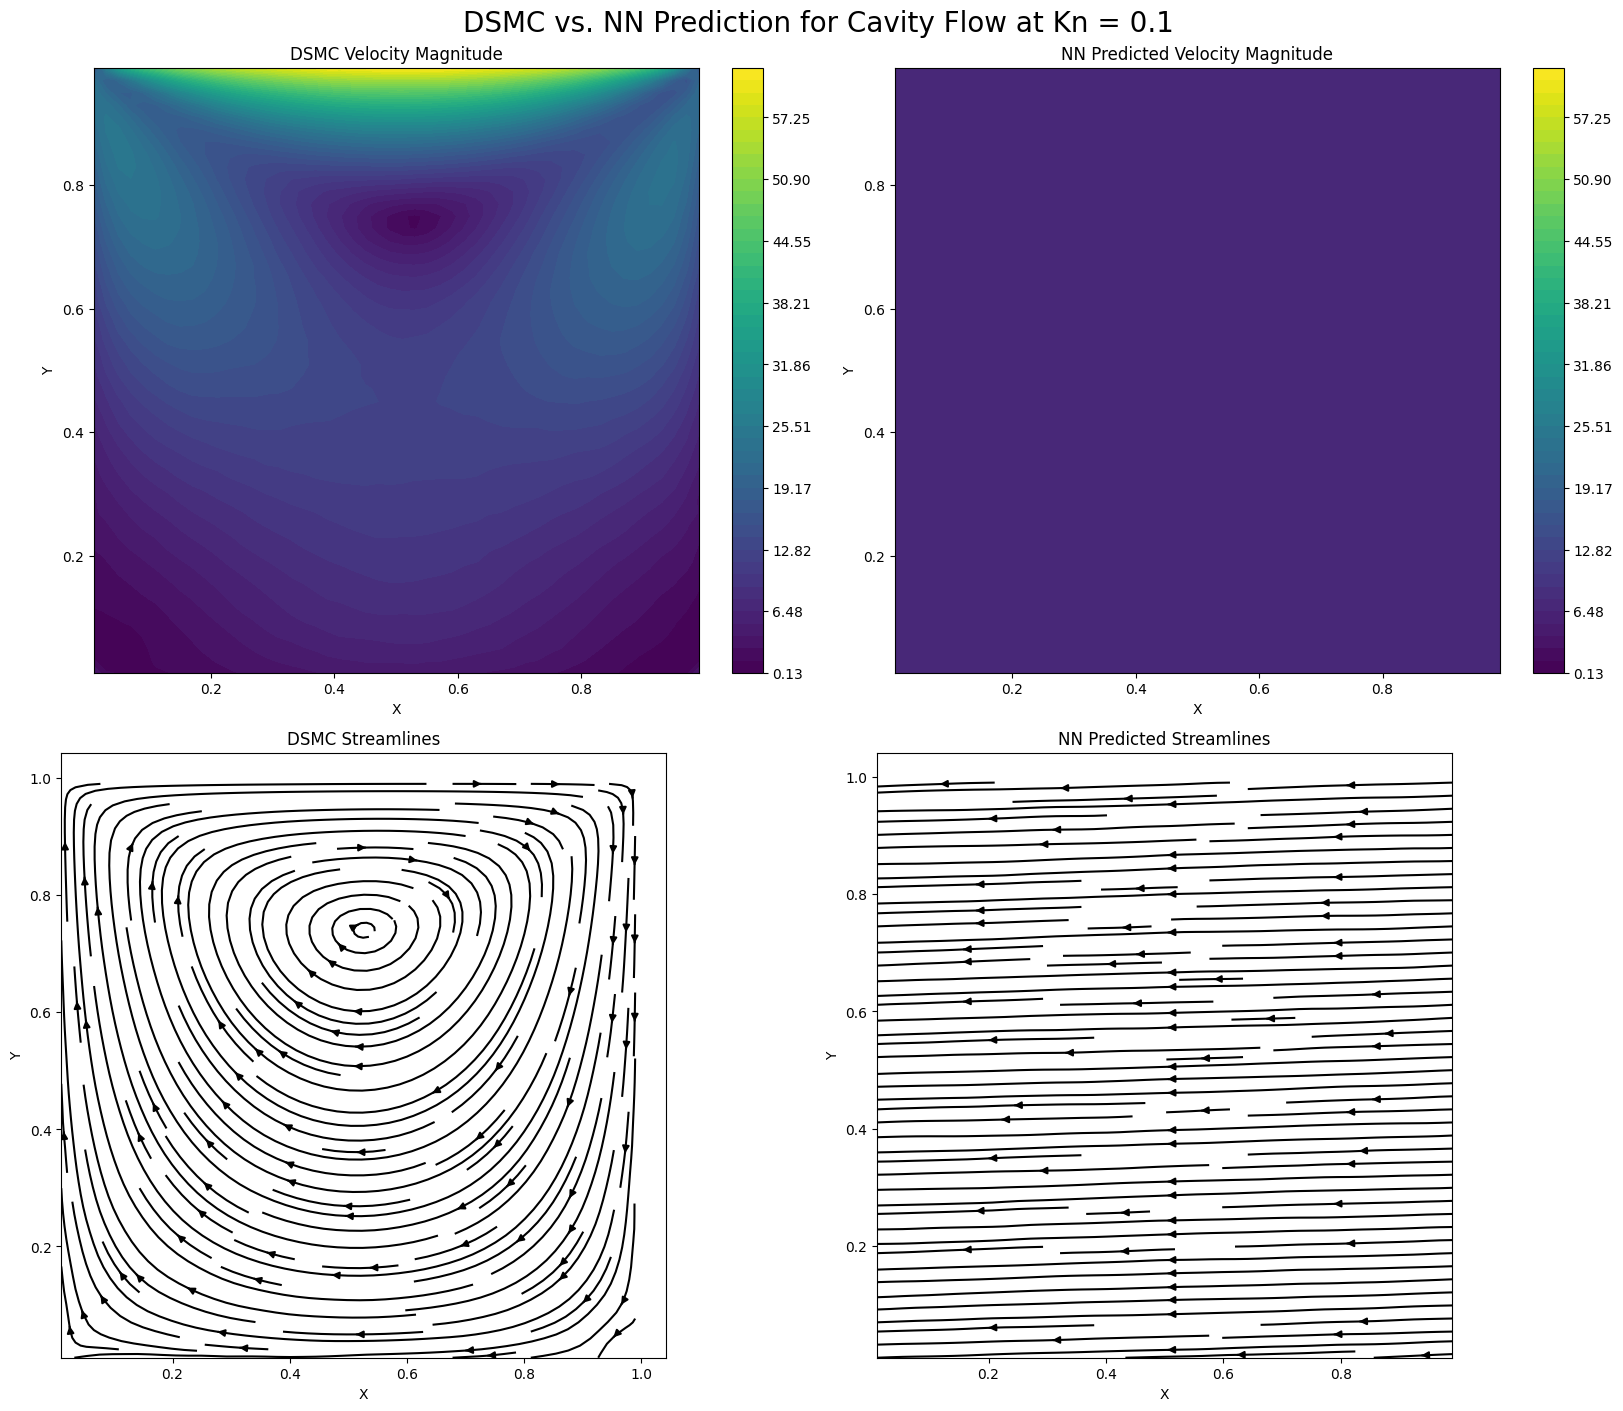

In [25]:
# --- گام ۵: ارزیابی و مصورسازی نتایج (با قابلیت ذخیره نمودار) ---

# --- Make Predictions on the Test Set ---
X_test_inputs = [X_test_scaled[:, :2], X_test_scaled[:, 2:]]
y_pred_scaled = model.predict(X_test_inputs)

# Inverse transform predictions to get back to physical values
y_pred = y_scaler.inverse_transform(y_pred_scaled)
# Create a DataFrame for the predicted output values
y_pred_df = pd.DataFrame(y_pred, columns=output_features)


# --- Visualization Function ---
def plot_comparison(ground_truth_df, df_pred, I, J, kn_value):
    """Plots a 2x2 comparison of contours and streamlines and saves the figure."""

    # Reshape data into a 2D grid for plotting
    X_grid = ground_truth_df['X'].values.reshape(J, I)
    Y_grid = ground_truth_df['Y'].values.reshape(J, I)

    # Calculate velocity magnitude for true and predicted data
    Vmag_true = np.sqrt(ground_truth_df['U']**2 + ground_truth_df['V']**2)
    Vmag_pred = np.sqrt(df_pred['U']**2 + df_pred['V']**2)

    Vmag_true_grid = Vmag_true.values.reshape(J, I)
    Vmag_pred_grid = Vmag_pred.values.reshape(J, I)

    # Get U and V components for streamlines
    U_true_grid = ground_truth_df['U'].values.reshape(J, I)
    V_true_grid = ground_truth_df['V'].values.reshape(J, I)
    U_pred_grid = df_pred['U'].values.reshape(J, I)
    V_pred_grid = df_pred['V'].values.reshape(J, I)

    fig, axes = plt.subplots(2, 2, figsize=(16, 14), constrained_layout=True)
    fig.suptitle(f'DSMC vs. NN Prediction for Cavity Flow at Kn = {kn_value}', fontsize=20)

    # --- Velocity Contours ---
    vmin = min(Vmag_true.min(), Vmag_pred.min())
    vmax = max(Vmag_true.max(), Vmag_pred.max())
    levels = np.linspace(vmin, vmax, 50)

    # DSMC
    cf1 = axes[0, 0].contourf(X_grid, Y_grid, Vmag_true_grid, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cf1, ax=axes[0, 0])
    axes[0, 0].set_title('DSMC Velocity Magnitude')
    axes[0, 0].set_xlabel('X')
    axes[0, 0].set_ylabel('Y')
    axes[0, 0].set_aspect('equal', adjustable='box')

    # NN Prediction
    cf2 = axes[0, 1].contourf(X_grid, Y_grid, Vmag_pred_grid, levels=levels, cmap='viridis', vmin=vmin, vmax=vmax)
    fig.colorbar(cf2, ax=axes[0, 1])
    axes[0, 1].set_title('NN Predicted Velocity Magnitude')
    axes[0, 1].set_xlabel('X')
    axes[0, 1].set_ylabel('Y')
    axes[0, 1].set_aspect('equal', adjustable='box')

    # --- Streamlines ---
    # DSMC
    axes[1, 0].streamplot(X_grid, Y_grid, U_true_grid, V_true_grid, density=1.5, color='k')
    axes[1, 0].set_title('DSMC Streamlines')
    axes[1, 0].set_xlabel('X')
    axes[1, 0].set_ylabel('Y')
    axes[1, 0].set_aspect('equal', adjustable='box')

    # NN Prediction
    axes[1, 1].streamplot(X_grid, Y_grid, U_pred_grid, V_pred_grid, density=1.5, color='k')
    axes[1, 1].set_title('NN Predicted Streamlines')
    axes[1, 1].set_xlabel('X')
    axes[1, 1].set_ylabel('Y')
    axes[1, 1].set_aspect('equal', adjustable='box')

    # ADDED: Save the figure to a file before showing it
    output_filename = f'comparison_kn_{kn_value}.jpg'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nFigure saved as '{output_filename}'")

    # Show the plot in the notebook
    plt.show()

# --- Plot the results for the test case ---
print("\nGenerating comparison plots...")
plot_comparison(test_df, y_pred_df, I, J, test_kn_value)